In [17]:
from PIL import Image
import numpy as np

def print_unique_colors(mask_path):
    mask = Image.open(mask_path).convert("RGB")
    mask_array = np.array(mask)
    pixels = mask_array.reshape(-1, 3)
    unique_colors = np.unique(pixels, axis=0)
    print("Unikalne kolory w masce:")
    for color in unique_colors:
        print(tuple(color))


In [18]:
print_unique_colors("data/masks/frame_000299_mask.png")

Unikalne kolory w masce:
(np.uint8(0), np.uint8(0), np.uint8(0))
(np.uint8(0), np.uint8(162), np.uint8(232))
(np.uint8(237), np.uint8(28), np.uint8(36))


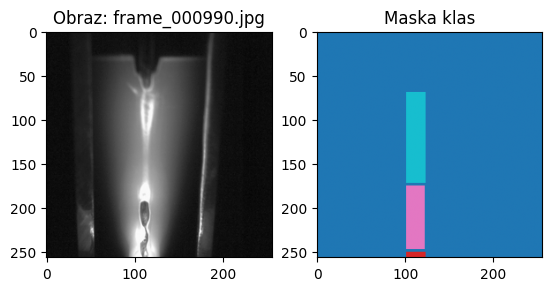

In [19]:
from dataset import ThermalSegmentationDataset
import matplotlib.pyplot as plt

dataset = ThermalSegmentationDataset("data/images", "data/masks", image_size=(256, 256))

# Sprawdzenie jednego przykładu
img, mask, name = dataset[2]

plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Obraz: {name}")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="tab10")
plt.title("Maska klas")
plt.show()


In [20]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = up_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.up3 = up_block(512, 256)
        self.dec3 = conv_block(512, 256)
        self.up2 = up_block(256, 128)
        self.dec2 = conv_block(256, 128)
        self.up1 = up_block(128, 64)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)


In [21]:
from torch.utils.data import random_split, DataLoader


dataset = ThermalSegmentationDataset("data/images", "data/masks", image_size=(256, 256))

# 80% trening, 20% walidacja
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [22]:
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet(in_channels=1, out_channels=4).to(DEVICE)  # 4 klasy: tło, łuk, spoina, kolumna ciepła
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()


In [23]:
NUM_EPOCHS = 100

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for images, masks, _ in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Walidacja
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks, _ in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


torch.save(model.state_dict(), "unet_segment_model.pth")


Epoch 1/100 | Train Loss: 1.3295 | Val Loss: 1.2917
Epoch 2/100 | Train Loss: 1.2954 | Val Loss: 1.2417
Epoch 3/100 | Train Loss: 1.2440 | Val Loss: 1.1147
Epoch 4/100 | Train Loss: 1.1132 | Val Loss: 0.6641
Epoch 5/100 | Train Loss: 0.8832 | Val Loss: 0.9336
Epoch 6/100 | Train Loss: 0.9364 | Val Loss: 0.9491
Epoch 7/100 | Train Loss: 0.9581 | Val Loss: 0.8863
Epoch 8/100 | Train Loss: 0.9029 | Val Loss: 0.7789
Epoch 9/100 | Train Loss: 0.8054 | Val Loss: 0.6335
Epoch 10/100 | Train Loss: 0.6745 | Val Loss: 0.4523
Epoch 11/100 | Train Loss: 0.5207 | Val Loss: 0.4648
Epoch 12/100 | Train Loss: 0.6682 | Val Loss: 0.3461
Epoch 13/100 | Train Loss: 0.4531 | Val Loss: 0.3282
Epoch 14/100 | Train Loss: 0.4457 | Val Loss: 0.3112
Epoch 15/100 | Train Loss: 0.4410 | Val Loss: 0.2949
Epoch 16/100 | Train Loss: 0.4334 | Val Loss: 0.2751
Epoch 17/100 | Train Loss: 0.4185 | Val Loss: 0.2512
Epoch 18/100 | Train Loss: 0.3956 | Val Loss: 0.2261
Epoch 19/100 | Train Loss: 0.3683 | Val Loss: 0.2044
Ep

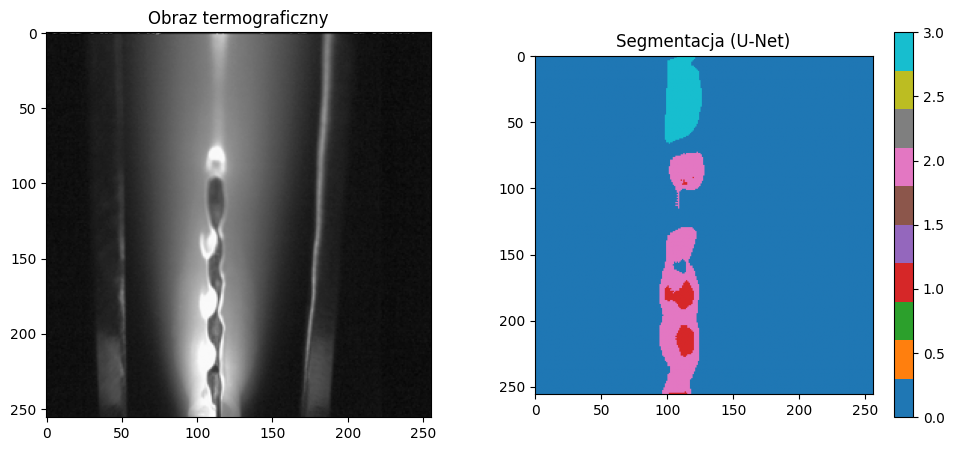

torch.Size([1, 4, 256, 256])


In [24]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from dataset import mask_to_class  # jeśli chcesz porównać z rzeczywistą maską


# seq_file_name = "600_41n20_1_2mm_-161_08_05_51_044"  # <- podmień na swoją sekwencję
seq_file_name = "625_38n18_1_2mm_-161_07_41_19_806"
image_file = "frame_001290"  # <- podmień na swój obraz
# --- ŚCIEŻKA DO OBRAZU ---
test_image_path = f"frames_output/{seq_file_name}/preview_fixed/{image_file}.jpg"  # <- podmień na swój obraz

# --- WCZYTANIE I PRZYGOTOWANIE OBRAZU ---
image = Image.open(test_image_path).convert("L").resize((256, 256))
input_tensor = transforms.ToTensor()(image).unsqueeze(0).to(DEVICE)  # (1, 1, 256, 256)

# --- WCZYTANIE MODELU ---
model = UNet(in_channels=1, out_channels=4).to(DEVICE)
model.load_state_dict(torch.load("unet_segment_model.pth"))
model.eval()

# --- PREDYKCJA ---
with torch.no_grad():
    output = model(input_tensor)
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# --- WIZUALIZACJA ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Obraz termograficzny")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="tab10")  # tab10 daje ładne kolory dla klas
plt.title("Segmentacja (U-Net)")
plt.colorbar()
plt.show()

print(output.shape)


In [25]:
print(output.shape)
unique_classes = np.unique(predicted_mask)
print("Unikalne klasy w masce predykcji:", unique_classes)
print("Unikalne klasy w predykcji:", np.unique(predicted_mask))


torch.Size([1, 4, 256, 256])
Unikalne klasy w masce predykcji: [0 1 2 3]
Unikalne klasy w predykcji: [0 1 2 3]


In [26]:
_, mask, name = dataset[0]
print("Maska z pliku:", name)
print("Unikalne klasy w masce:", torch.unique(mask))


Maska z pliku: frame_000299.jpg
Unikalne klasy w masce: tensor([0, 1, 3])
